<a href="https://colab.research.google.com/github/harikang/harikang/blob/main/stylegan3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 필요한 라이브러리 설치

In [1]:
import sys
print(sys.version)

3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/stylegan2-ada-pytorch')

In [ ]:
import torch
import pickle
import copy
import os
from time import perf_counter
import click
import imageio
import numpy as np
import PIL.Image
import torch
import torch.nn.functional as F
import dnnlib
import legacy
import os
import re
from typing import List
import click

# 드라이브 마운트 및 경로 설정

In [ ]:
# !git clone https://github.com/NVlabs/stylegan3.git

Cloning into 'stylegan3'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 212 (delta 0), reused 1 (delta 0), pack-reused 207
Receiving objects: 100% (212/212), 4.17 MiB | 1.53 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [ ]:
!export PYTHONPATH=.

In [ ]:
%pwd

'/content/drive/MyDrive/stylegan2-ada-pytorch'

In [ ]:
#error 방지를 위해 ninja를 설치 (ninja가 뭔진 모름)
# !wget https://github.com/ninja-build/ninja/releases/download/v1.10.2/ninja-linux.zip #이 코드는 한번만 실행
!sudo unzip ninja-linux.zip -d //content/drive/MyDrive/stylegan2-ada-pytorch
!sudo update-alternatives --install //content/drive/MyDrive/stylegan2-ada-pytorch ninja //content/drive/MyDrive/stylegan2-ada-pytorch/ --force

Archive:  ninja-linux.zip
replace //content/drive/MyDrive/stylegan2-ada-pytorch/ninja? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: //content/drive/MyDrive/stylegan2-ada-pytorch/ninja  
update-alternatives: priority must be an integer

Use 'update-alternatives --help' for program usage information.


In [ ]:
#error 방지를 위해 ninja를 설치 (ninja가 뭔진 모름)
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force
# !watch -d -n 0.5 free -m

Archive:  ninja-linux.zip
  inflating: /usr/local/bin/ninja    
update-alternatives: using /usr/local/bin/ninja to provide /usr/bin/ninja (ninja) in auto mode


In [ ]:
#결과 저장을 위한 디렉토리 생성
# !mkdir training-runs

In [ ]:
#train에 사용할 수 있는 dataset.zip 형태로 변경하는 py파일 돌림.
# !python dataset_tool.py  --source /content/drive/MyDrive/stylegan3/closed_eyes  --dest /content/drive/MyDrive/stylegan3/training-runs/dataset.zip  --transform=center-crop-wide --resolution=512x512

100% 1908/1908 [01:07<00:00, 28.41it/s]


In [ ]:
# @title 후보 train 방법
# # Train StyleGAN3-T for AFHQv2 using 8 GPUs.
# python train.py --outdir=~/training-runs --cfg=stylegan3-t --data=~/datasets/afhqv2-512x512.zip \
#     --gpus=8 --batch=32 --gamma=8.2 --mirror=1

# # Fine-tune StyleGAN3-R for MetFaces-U using 1 GPU, starting from the pre-trained FFHQ-U pickle.
# python train.py --outdir=~/training-runs --cfg=stylegan3-r --data=~/datasets/metfacesu-1024x1024.zip \
#     --gpus=8 --batch=32 --gamma=6.6 --mirror=1 --kimg=5000 --snap=5 \
#     --resume=https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhqu-1024x1024.pkl

# # Train StyleGAN2 for FFHQ at 1024x1024 resolution using 8 GPUs.
# python train.py --outdir=~/training-runs --cfg=stylegan2 --data=~/datasets/ffhq-1024x1024.zip \
#     --gpus=8 --batch=32 --gamma=10 --mirror=1 --aug=noaug


In [ ]:
# @title 후보 train 예시
# !python train.py --outdir=/content/drive/MyDrive/stylegan3/training-runs --cfg=stylegan3-r --data=/content/drive/MyDrive/stylegan3/training-runs/dataset.zip  --gpus=1 --batch=4 --gamma=6.6 --mirror=1 --kimg=1000 --snap=5 --resume=https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhqu-1024x1024.pkl --workers 1

python 명령어로 train 진행 (일단 5000개의 이미지만 돌림)

In [ ]:
%pwd

'/content/drive/My Drive/stylegan2-ada-pytorch'

In [ ]:
# @title train
# !python train.py --outdir=/content/drive/MyDrive/stylegan3/training-runs --cfg=stylegan3-t --data=/content/drive/MyDrive/stylegan3/training-runs/dataset.zip --gpus=1 --batch=4 --gamma=8.2 --mirror=1 --kimg=1 --snap=5  --workers 1
# !python train.py --outdir=/content/drive/MyDrive/stylegan3/training-runs --data=/content/drive/MyDrive/stylegan3/training-runs/dataset.zip --gpus=1 --batch=4 --gamma=8.2 --mirror=1 --kimg=1 --snap=5  --workers 1

Ultrasound 2 Latent vector (초음파 이미지를 z vector로 변경)

In [ ]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 1.12 MiB | 14.17 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [ ]:
%pwd

'/content/drive/MyDrive/stylegan3/stylegan2-ada-pytorch'

In [ ]:
#생성될 결과를 저장할 디렉토리 생성

In [ ]:
%pwd

'/content/drive/MyDrive/stylegan2-ada-pytorch'

In [ ]:
#Project given image to the latent space of pretrained network pickle. ->python 명령어로 실행하는 방법
# python projector.py --outdir=out --target=~/mytargetimg.png --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl

# 초음파 이미지를 latent vector로 project하는 코드

In [ ]:
def project(
    G,
    target: torch.Tensor, # [C,H,W] and dynamic range [0,255], W & H must match G output resolution
    *,
    num_steps                  = 1000,
    w_avg_samples              = 1000,
    initial_learning_rate      = 0.1,
    initial_noise_factor       = 0.05,
    lr_rampdown_length         = 0.25,
    lr_rampup_length           = 0.05,
    noise_ramp_length          = 0.75,
    regularize_noise_weight    = 1e5,
    verbose                    = False,
    device: torch.device
):
    assert target.shape == (G.img_channels, G.img_resolution, G.img_resolution)

    def logprint(*args):
        if verbose:
            print(*args)

    G = copy.deepcopy(G).eval().requires_grad_(False).to(device) # type: ignore

    # Compute w stats.
    logprint(f'Computing W midpoint and stddev using {w_avg_samples} samples...')
    z_samples = np.random.RandomState(123).randn(w_avg_samples, G.z_dim)
    w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
    w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)       # [N, 1, C]
    w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 1, C]
    w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

    # Setup noise inputs.
    noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }

    # Load VGG16 feature detector.
    url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
    with dnnlib.util.open_url(url) as f:
        vgg16 = torch.jit.load(f).eval().to(device)
        print(vgg16)

    # Features for target image.
    target_images = target.unsqueeze(0).to(device).to(torch.float32)
    if target_images.shape[2] > 256:
        target_images = F.interpolate(target_images, size=(256, 256), mode='area')
    target_features = vgg16(target_images, resize_images=False, return_lpips=True)

    w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) # pylint: disable=not-callable
    w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device)
    optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_learning_rate)

    # Init noise.
    for buf in noise_bufs.values():
        buf[:] = torch.randn_like(buf)
        buf.requires_grad = True

    for step in range(num_steps):
        # Learning rate schedule.
        t = step / num_steps
        w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
        lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
        lr = initial_learning_rate * lr_ramp
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # Synth images from opt_w.
        w_noise = torch.randn_like(w_opt) * w_noise_scale
        ws = (w_opt + w_noise).repeat([1, G.mapping.num_ws, 1])
        synth_images = G.synthesis(ws, noise_mode='const')

        # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
        synth_images = (synth_images + 1) * (255/2)
        if synth_images.shape[2] > 256:
            synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')

        # Features for synth images.
        synth_features = vgg16(synth_images, resize_images=False, return_lpips=True)
        dist = (target_features - synth_features).square().sum()

        # Noise regularization.
        reg_loss = 0.0
        for v in noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)
        loss = dist + reg_loss * regularize_noise_weight

        # Step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        logprint(f'step {step+1:>4d}/{num_steps}: dist {dist:<4.2f} loss {float(loss):<5.2f}')

        # Save projected W for each optimization step.
        w_out[step] = w_opt.detach()[0]

        # Normalize noise.
        with torch.no_grad():
            for buf in noise_bufs.values():
                buf -= buf.mean()
                buf *= buf.square().mean().rsqrt()

    return w_out.repeat([1, G.mapping.num_ws, 1])

In [ ]:
%pwd

'/content/drive/MyDrive/stylegan2-ada-pytorch'

In [ ]:
# !mkdir training-runs3

NotImplementedError: ignored

In [ ]:
outdir = '/content/drive/MyDrive/stylegan2-ada-pytorch/training-runs3'

In [ ]:
# random한 seed 설정
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

# Load networks.
print('Loading networks')
device = torch.device('cuda')
with open('/content/drive/MyDrive/stylegan2-ada-pytorch/network-snapshot-003600.pkl', 'rb') as f:
    G = legacy.load_network_pkl(f)['G'].requires_grad_(False).to(device)
# Load target image.
#초음파 이미지의 경로를 설정
target_fname = '/content/kongdak3.jpg'

target_pil = PIL.Image.open(target_fname).convert('RGB')
# plt.imshow(target_pil)
w, h = target_pil.size
s = min(w, h)
target_pil = target_pil.crop(((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2))
target_pil = target_pil.resize((G.img_resolution, G.img_resolution), PIL.Image.LANCZOS)
target_uint8 = np.array(target_pil, dtype=np.uint8)

# Optimize projection.-> 최적의 projection을 위한 학습을 진행
start_time = perf_counter()
projected_w_steps = project(
    G,
    target=torch.tensor(target_uint8.transpose([2, 0, 1]), device=device), # pylint: disable=not-callable
    num_steps=1000,
    device=device,
    verbose=True
)
print (f'Elapsed: {(perf_counter()-start_time):.1f} s')



Loading networks
Computing W midpoint and stddev using 1000 samples...
RecursiveScriptModule(
  original_name=VGG16
  (layers): RecursiveScriptModule(
    original_name=ModuleDict
    (conv1): RecursiveScriptModule(original_name=Conv2dLayer)
    (conv2): RecursiveScriptModule(original_name=Conv2dLayer)
    (pool1): RecursiveScriptModule(original_name=MaxPool2d)
    (conv3): RecursiveScriptModule(original_name=Conv2dLayer)
    (conv4): RecursiveScriptModule(original_name=Conv2dLayer)
    (pool2): RecursiveScriptModule(original_name=MaxPool2d)
    (conv5): RecursiveScriptModule(original_name=Conv2dLayer)
    (conv6): RecursiveScriptModule(original_name=Conv2dLayer)
    (conv7): RecursiveScriptModule(original_name=Conv2dLayer)
    (pool3): RecursiveScriptModule(original_name=MaxPool2d)
    (conv8): RecursiveScriptModule(original_name=Conv2dLayer)
    (conv9): RecursiveScriptModule(original_name=Conv2dLayer)
    (conv10): RecursiveScriptModule(original_name=Conv2dLayer)
    (pool4): Recurs

In [ ]:
os.makedirs(outdir, exist_ok=True)

In [ ]:
#저장할 번호
imgnum='kongdak3_weight3600_0823'

만드는 과정이 비디오로 저장됨+projected_w가 out 폴더에 저장됨

style mixing 코드로 초음파이미지로부터 z를 얻고 신생아이미지로 학습한 가중치를 더함.

In [ ]:
# @title style mixing -1
def num_range(s: str) -> List[int]:
    '''Accept either a comma separated list of numbers 'a,b,c' or a range 'a-c' and return as a list of ints.'''

    range_re = re.compile(r'^(\d+)-(\d+)$')
    m = range_re.match(s)
    if m:
        return list(range(int(m.group(1)), int(m.group(2))+1))
    vals = s.split(',')
    return [int(x) for x in vals]

In [ ]:
# @title style mixing -2
def generate_style_mix(
    network_pkl: str,
    row_seeds: List[int],
    col_seeds: List[int],
    col_styles: List[int],
    truncation_psi: float,
    noise_mode: str,
    outdir: str
):
    print('Loading networks')
    device = torch.device('cuda')
    with open('/content/drive/MyDrive/stylegan3/training-runs/00006-stylegan3-t-dataset-gpus1-batch4-gamma8.2/network-snapshot-000001.pkl', 'rb') as f:
        G = pickle.load(f)['G'].cuda()
    #출력물이 위치할 directory 설정
    outdir = '/content/drive/MyDrive/stylegan3/stylegan2-ada-pytorch/out'
    os.makedirs(outdir, exist_ok=True)

    print('Generating W vectors...')
    all_seeds = list(set(row_seeds + col_seeds))
    all_z = np.stack([np.random.RandomState(seed).randn(G.z_dim) for seed in all_seeds])
    all_w = G.mapping(torch.from_numpy(all_z).to(device), None)
    w_avg = G.mapping.w_avg
    all_w = w_avg + (all_w - w_avg) * truncation_psi
    w_dict = {seed: w for seed, w in zip(all_seeds, list(all_w))}

    print('Generating images...')
    all_images = G.synthesis(all_w, noise_mode=noise_mode)
    all_images = (all_images.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8).cpu().numpy()
    image_dict = {(seed, seed): image for seed, image in zip(all_seeds, list(all_images))}

    print('Generating style-mixed images...')
    for row_seed in row_seeds:
        for col_seed in col_seeds:
            w = w_dict[row_seed].clone()
            w[col_styles] = w_dict[col_seed][col_styles]
            image = G.synthesis(w[np.newaxis], noise_mode=noise_mode)
            image = (image.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
            image_dict[(row_seed, col_seed)] = image[0].cpu().numpy()

    print('Saving images...')
    os.makedirs(outdir, exist_ok=True)
    for (row_seed, col_seed), image in image_dict.items():
        PIL.Image.fromarray(image, 'RGB').save(f'{outdir}/{row_seed}-{col_seed}.png')

    print('Saving image grid...')
    W = G.img_resolution
    H = G.img_resolution
    canvas = PIL.Image.new('RGB', (W * (len(col_seeds) + 1), H * (len(row_seeds) + 1)), 'black')
    for row_idx, row_seed in enumerate([0] + row_seeds):
        for col_idx, col_seed in enumerate([0] + col_seeds):
            if row_idx == 0 and col_idx == 0:
                continue
            key = (row_seed, col_seed)
            if row_idx == 0:
                key = (col_seed, col_seed)
            if col_idx == 0:
                key = (row_seed, row_seed)
            canvas.paste(PIL.Image.fromarray(image_dict[key], 'RGB'), (W * col_idx, H * row_idx))
    canvas.save(f'{outdir}/grid.png')



In [ ]:
# @title style mixing -3
generate_style_mix()

# 초음파 이미지로부터 생성된 z벡터를 통해 img를 생성

In [ ]:
# # # Save final projected frame and W vector.target_pil.save(f'{outdir}/target.png')
# projected_w = projected_w_steps[-1]
# synth_image = G.synthesis(projected_w.unsqueeze(0), noise_mode='const')
# synth_image = (synth_image + 1) * (255/2)
# synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
# PIL.Image.fromarray(synth_image, 'RGB').save(f'{outdir}/proj.png')
# np.savez(f'{outdir}/projected_w3.npz', w=projected_w.unsqueeze(0).cpu().numpy())

In [ ]:
# # Save final projected frame
projected_w = projected_w_steps[-1]
synth_image = G(projected_w.cuda(), None)
synth_image = (synth_image + 1) * (255/2) #N(0,1) -> RGB값으로
synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
PIL.Image.fromarray(synth_image, 'RGB').save(f'{outdir}/targe_{imgnum}.png')

In [ ]:
# # #압축된 npz 파일을 볼 수 있는 배열 형태로 변경
# a=np.load('/content/drive/MyDrive/stylegan2-ada-pytorch/training-runs/projected_w3.npz')
# w_vector = a['w']

In [ ]:
video = imageio.get_writer(f'{outdir}/proj_{imgnum}.mp4', mode='I', fps=100, codec='libx264', bitrate='16M')
print (f'Saving optimization progress video "{outdir}/proj_{imgnum}.mp4"')
for projected_w in projected_w_steps:
    synth_image = G.synthesis(projected_w.unsqueeze(0), noise_mode='const')
    synth_image = G(projected_w.cuda(), None)
    synth_image = (synth_image + 1) * (255/2) #N(0,1) -> RGB값으로
    synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy() #이미지화
    video.append_data(np.concatenate([target_uint8, synth_image], axis=1))
video.close()

Saving optimization progress video "/content/drive/MyDrive/stylegan2-ada-pytorch/training-runs2/proj_test1_0822.mp4"


In [ ]:
##################################################################################################################################################

In [ ]:
# z = projected_w[-1]
tensorz = torch.Tensor(z)
tensorz_with_batch = tensorz.unsqueeze(0)

In [ ]:
with open('/content/drive/MyDrive/stylegan2-ada-pytorch/network-snapshot-003600.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module
c = None                                # class labels (not used in this example)
img = G(tensorz_with_batch.cuda(), c)                           # NCHW, float32, dynamic range [-1, +1], no truncation

In [ ]:
synth_image =img.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
PIL.Image.fromarray(synth_image, 'RGB').save(f'{outdir}/target.png')

In [ ]:
img1=img.permute(0,2,3,1)

torch.Size([1, 3, 512, 512])


In [ ]:
img1 = img1.squeeze(0)

In [ ]:
import numpy as np
img2 = img1.cpu().numpy()

In [ ]:
print(img1.shape)

torch.Size([512, 512, 3])


In [ ]:
img2.shape

(512, 512, 3)

In [ ]:
# import cv2
# succ, enc_image = cv2.imencode('.jpg', img2)
# image_bytes = enc_image.tobytes()
# plt.imshow(
#     cv2.cvtColor(image_bytes, cv2.COLOR_BGR2RGB)
#     )
# plt.show()​

In [ ]:
img2 = (img2 +1)*(255/2)

In [ ]:
plt.savefig('test_graph.png',
            facecolor='#eeeeee',
            edgecolor='black',
            format='png', dpi=200)

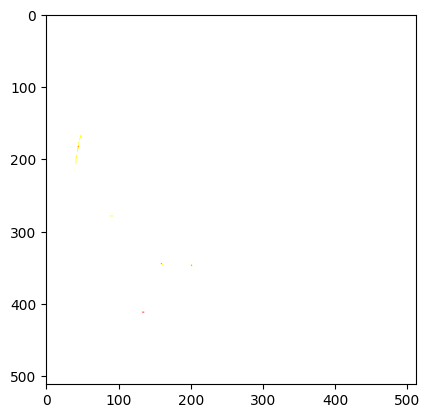

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img2)